In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

2024-03-07 16:39:47.764264: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-07 16:39:47.964950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 16:39:47.965001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 16:39:47.968670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 16:39:47.977752: I tensorflow/core/platform/cpu_feature_guar

In [2]:
IMAGE_SIZE=300
BATCH_SIZE=16
CHANNELS=3

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2746 files belonging to 5 classes.


2024-03-07 16:39:54.697116: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 16:39:54.753515: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 16:39:54.753588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 16:39:54.756283: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 16:39:54.756407: I external/local_xla/xla/stream_executor

In [4]:
class_names=dataset.class_names
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [5]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

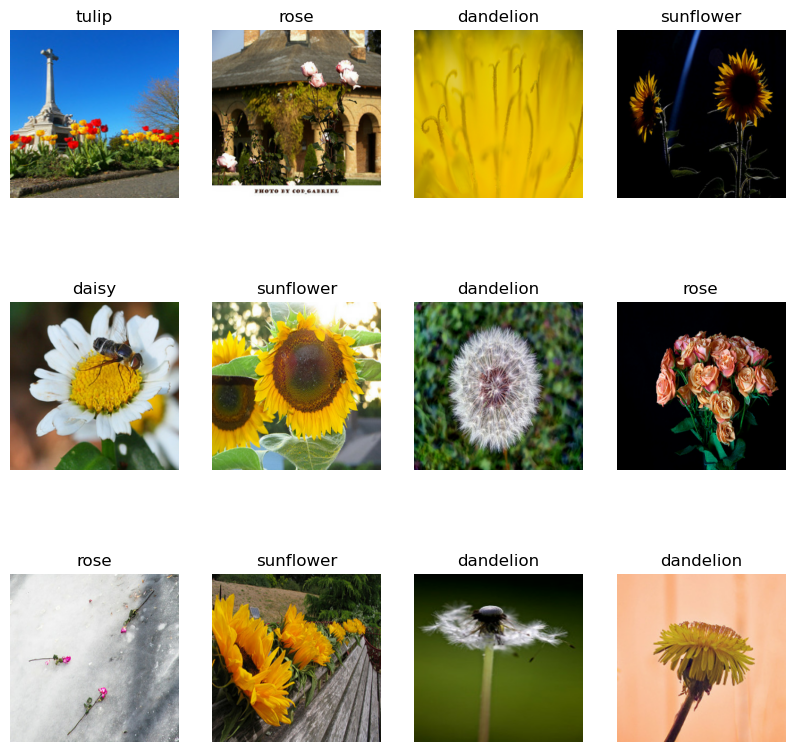

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [7]:
def get_dataset_partitions_tf(ds,train_split=.8,val_split=.1,test_split=.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [8]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [11]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(.2),
])

In [12]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (2,2), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (2,2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (2,2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 300, 300, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 299, 299, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2  (16, 149, 149, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 148, 148, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 74, 74, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (16, 73, 73, 64)         

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
)

Epoch 1/40


2024-03-07 16:40:07.273460: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-07 16:40:08.178232: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f87c88bbc00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-07 16:40:08.178292: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2024-03-07 16:40:08.189250: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709809808.313045    8723 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-03-07 16:40:10.798018: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.53GiB with freed_by_count=0. The caller indicates 

137/137 [==============================] - 36s 155ms/step - loss: 1.4293 - accuracy: 0.3399 - val_loss: 1.2258 - val_accuracy: 0.4191
Epoch 2/40
137/137 [==============================] - 15s 108ms/step - loss: 1.1656 - accuracy: 0.5018 - val_loss: 1.0439 - val_accuracy: 0.5515
Epoch 3/40
137/137 [==============================] - 14s 104ms/step - loss: 1.0633 - accuracy: 0.5480 - val_loss: 0.9757 - val_accuracy: 0.5846
Epoch 4/40
137/137 [==============================] - 15s 109ms/step - loss: 1.0259 - accuracy: 0.5805 - val_loss: 0.9526 - val_accuracy: 0.6029
Epoch 5/40
137/137 [==============================] - 15s 106ms/step - loss: 0.9551 - accuracy: 0.6075 - val_loss: 0.8671 - val_accuracy: 0.6324
Epoch 6/40
137/137 [==============================] - 15s 106ms/step - loss: 0.9286 - accuracy: 0.6185 - val_loss: 0.8796 - val_accuracy: 0.6287
Epoch 7/40
137/137 [==============================] - 14s 105ms/step - loss: 0.8768 - accuracy: 0.6359 - val_loss: 0.8266 - val_accuracy: 0.6

In [17]:
scores = model.evaluate(test_ds)
scores

18/18 [==============================] - 3s 25ms/step - loss: 0.4633 - accuracy: 0.8229


[0.46326228976249695, 0.8229166865348816]

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

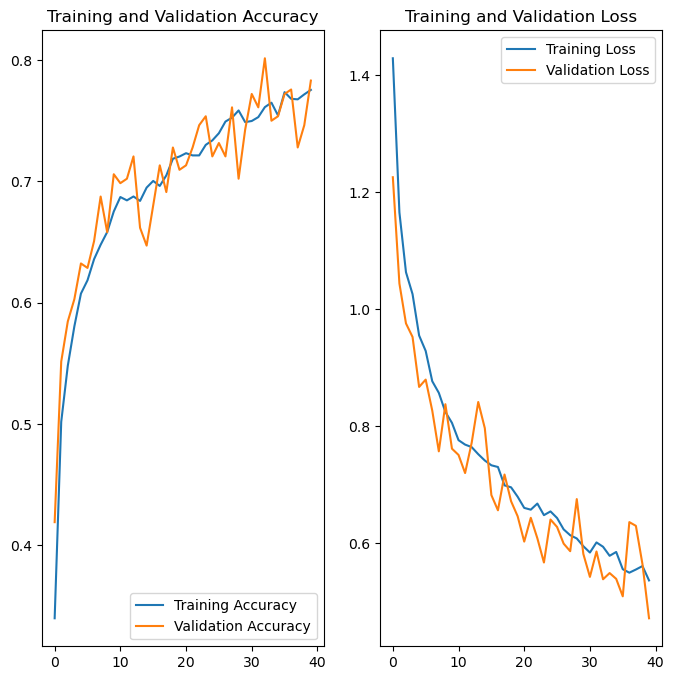

In [19]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(40), acc, label='Training Accuracy')
plt.plot(range(40), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(40), loss, label='Training Loss')
plt.plot(range(40), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: dandelion
1/1 [==============================] - 1s 859ms/step
predicted label: dandelion


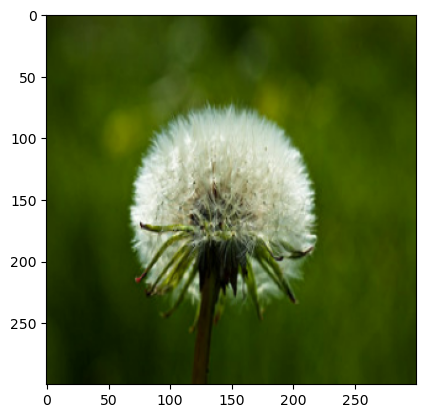

In [20]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [133]:
test_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "test",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=14
)

Found 924 files belonging to 1 classes.


first image to predict
1/1 [==============================] - 1s 810ms/step
predicted label: tulip


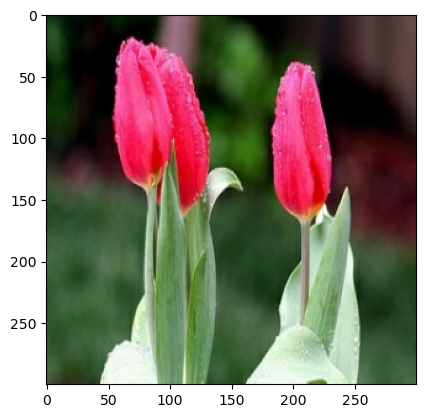

In [134]:
for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

1/1 [==============================] - 0s 20ms/step


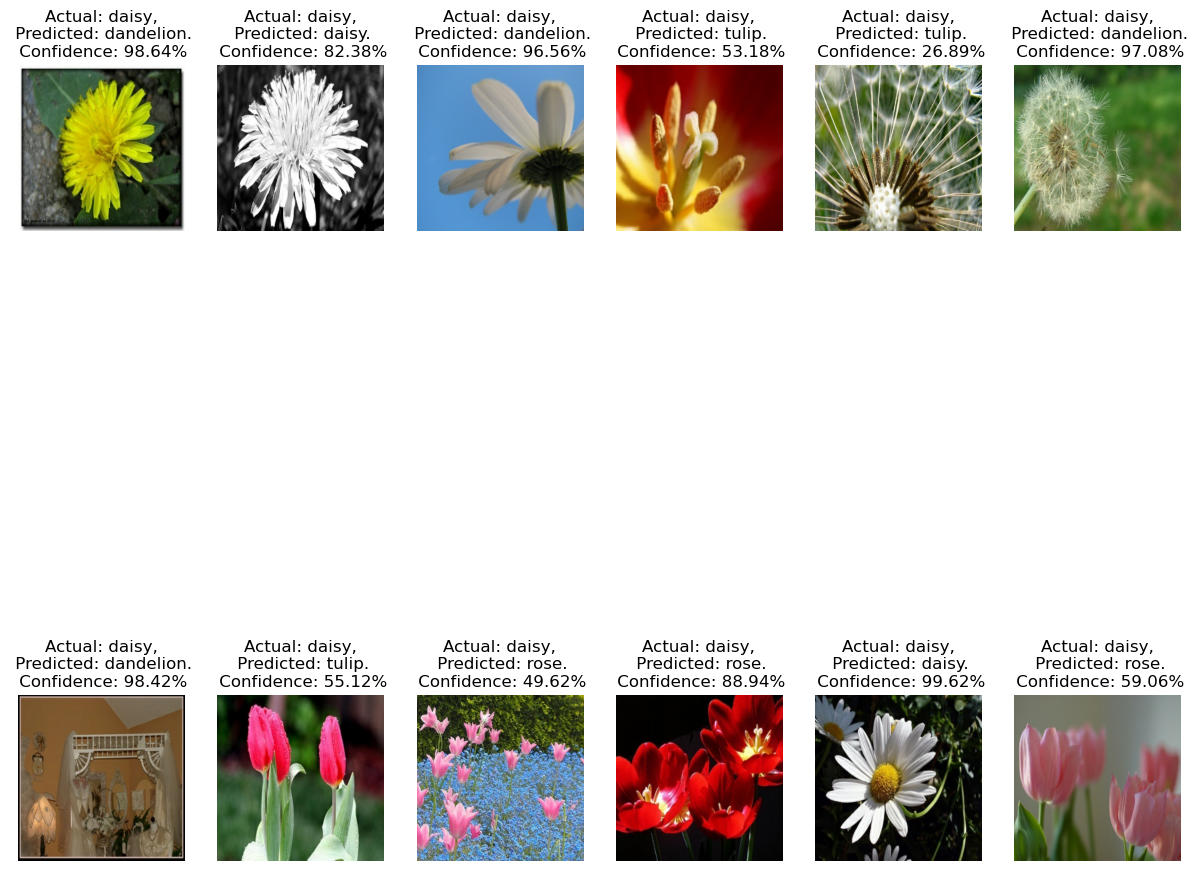

In [137]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(2,6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [128]:
pred=[]
conf=[]
li=[]
x=0
for images, labels in test_dataset.take(66):
    for i in range(12):
        x=x+1
        img=f'Pics({x}).jpg'
        predicted_class, confidence = predict(model, images[i].numpy())
        pred.append(predicted_class)
        conf.append(confidence)
        li.append(img)

1/1 [==============================] - 0s 22ms/step


In [129]:
lot=list(zip(li,pred,conf))

In [130]:
df=pd.DataFrame(data=lot,columns=['name','pred','comf'])

In [131]:
df.to_csv("file1.csv")